# Import Packages & Data

In [2]:
# Never do this, but warnings are annoying so I'm blocking them
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold

from gensim.models.word2vec import Word2Vec
from gensim.test.utils import datapath

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
import language_tool
import spacy

from sklearn.model_selection import train_test_split, KFold

from skll.metrics import kappa
from bhkappa import mean_quadratic_weighted_kappa

from scipy.sparse import csr_matrix

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasRegressor

import nltk
stopwords = stopwords.words('english')

%matplotlib inline

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Using TensorFlow backend.


Numpy version: 1.17.3
Pandas version: 0.24.2
Seaborn version: 0.9.0


In [3]:
# Installs SpaCy Framework
nlp = spacy.load("en_core_web_lg")

In [4]:
training_set  = pd.read_csv('data/training_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.head(3)

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
valid_set  = pd.read_csv('data/valid_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})
test_set  = pd.read_csv('data/test_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})
combo_set = pd.concat([valid_set, test_set], sort=False)

# Apply grammar and spelling corrections

Feature importances generated from the extra trees algorithm did not rank grammar and spelling errors highly, suggesting that perhaps the essays could be processed "as is". On the other hand, word embeddings rely on known words and many usage examples. Misspelled words will either be ignored if their count is below the minimum, or worse, if misspelled to an existing word with a different meaning, the vectors could change the performance of the model in a way that might not be useful. LanguageTool will be used for applying these corrections.

Language_tool has been the biggest pain to deal with in this whole project. Here's how to fix the implimentation.
Start the server using [this solution](https://stackoverflow.com/questions/45412823/python-2-7-grammar-check-1-3-1-library-http-error-400-bad-request?rq=1)

[Here's how to clear port 8081](https://stackoverflow.com/questions/39632667/how-to-kill-the-process-currently-using-a-port-on-localhost-in-windows)

**cd to this folder**

```cd C:\Users\David\Anaconda3\Lib\site-packages\language_tool\LanguageTool-3.2```

**Clear out port 8081**

```netstat -ano | findstr :8081```

```taskkill /PID typeyourPIDhere /F```


**Start the server using**

```java -cp languagetool-server.jar org.languagetool.server.HTTPServer --port 8081```

In [1]:
# Correction using Language-Tool
def correct_language(df):
    df['matches'] = df['essay'].apply(lambda txt: tool.check(txt))
    df['corrections'] = df.apply(lambda l: len(l['matches']), axis=1)
    df['corrected'] = df.apply(lambda l: language_tool.correct(l['essay'], l['matches']), axis=1)
      
    return df

In [14]:
# Apply corrections
tool = language_check.LanguageTool('en-US')
combo_set = correct_language(combo_set)
training_set = correct_language(training_set)

# Generate word embeddings

I'm considering using a generic SpaCy or GloVe embedding on the data to compare results, but I'm currently using SSWEs because they're more representative of prompt-specific lexicons

## Using Word2Vec

In [15]:
# Create one dataset with all essays
combo_set = pd.concat([combo_set, training_set], sort=False)
len(combo_set)

21448

In [19]:
# Clean training_set essays before feeding them to the Word2Vec model.
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_essays(essays, logging=False):
    texts = []
    counter = 1
    for essay in essays.corrected:
        if counter % 2000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(essays)))
        counter += 1
        essay = nlp(essay, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in essay if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [20]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', training_set['corrected'].shape)
cleaned_essays = cleanup_essays(training_set, logging=True)
train_cleaned = pd.concat([training_set['topic'], cleaned_essays], axis=1)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (12976,)
Processed 2000 out of 12976 documents.
Processed 4000 out of 12976 documents.
Processed 6000 out of 12976 documents.
Processed 8000 out of 12976 documents.
Processed 10000 out of 12976 documents.
Processed 12000 out of 12976 documents.
Cleaned up training data shape:  (12976, 2)


In [21]:
# Define function to preprocess text for a word2vec model
def cleanup_essay_word2vec(essays, logging=False):
    sentences = []
    counter = 1
    for essay in essays:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(essays)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        essay = nlp(essay, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        essay = " ".join([tok.lemma_.lower() for tok in essay])
        # Split into sentences based on punctuation
        essay = re.split("[\.?!;] ", essay)
        # Remove commas, periods, and other punctuation (mostly commas)
        essay = [re.sub("[\.,;:!?]", "", sent) for sent in essay]
        # Split into words
        essay = [sent.split() for sent in essay]
        sentences += essay
        counter += 1
    return sentences

In [38]:
# Create SSWEs
text_dim = 300

# Embedding for all prompts
cleaned_word2vec = cleanup_essay_word2vec(combo_set['corrected'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(cleaned_word2vec))
print("Training Word2Vec model...")
wordvec_model = Word2Vec(cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))
wordvec_model.save('prompt_all.model')
print("Word2Vec model saved.")

# Prompt-Specific Embeddings
for x in range(8):
    prompt = x+1
    print("PROMPT %d" % prompt)
    cleaned_word2vec = cleanup_essay_word2vec(combo_set.loc[combo_set['topic'] == prompt]['corrected'], logging=True)
    print('Cleaned up training data size (i.e. number of sentences): ', len(cleaned_word2vec))
    print("Training Word2Vec model...")
    wordvec_model = Word2Vec(cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
    print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))
    wordvec_model.save('prompt_%d.model' % prompt)
    print("Word2Vec model saved.")

Processed 1000 out of 21448 documents
Processed 2000 out of 21448 documents
Processed 3000 out of 21448 documents
Processed 4000 out of 21448 documents
Processed 5000 out of 21448 documents
Processed 6000 out of 21448 documents
Processed 7000 out of 21448 documents
Processed 8000 out of 21448 documents
Processed 9000 out of 21448 documents
Processed 10000 out of 21448 documents
Processed 11000 out of 21448 documents
Processed 12000 out of 21448 documents
Processed 13000 out of 21448 documents
Processed 14000 out of 21448 documents
Processed 15000 out of 21448 documents
Processed 16000 out of 21448 documents
Processed 17000 out of 21448 documents
Processed 18000 out of 21448 documents
Processed 19000 out of 21448 documents
Processed 20000 out of 21448 documents
Processed 21000 out of 21448 documents
Cleaned up training data size (i.e. number of sentences):  285088
Training Word2Vec model...
10366 unique words represented by 300 dimensional vectors
Word2Vec model saved.
PROMPT 1
Processe

In [39]:
# Define function to create averaged word vectors given a cleaned text. 
def create_average_vec(essay):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in essay.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [24]:
# Create prompt-inspecific word vectors
cleaned_vec = np.zeros((training_set.shape[0], text_dim), dtype="float32")  
wordvec_model = Word2Vec.load("embeddings/prompt_all.model")
for i in range(len(train_cleaned)):
    cleaned_vec[i] = create_average_vec(train_cleaned[0][i])
print("Word vectors for essays is in the shape:", cleaned_vec.shape)

Word vectors for essays is in the shape: (12976, 300)


In [40]:
# Creates prompt-specific word vectors
cleaned_vec = np.zeros((train_cleaned.shape[0], text_dim), dtype="float32")  

for x in range(8):
    prompt = x+1
    wordvec_model = Word2Vec.load("embeddings/prompt_%d.model" % prompt)
    for i in range(len(train_cleaned.loc[train_cleaned["topic"] == prompt])):
        cleaned_vec[train_cleaned[train_cleaned["topic"] == prompt].index[i]] = create_average_vec(train_cleaned[0][train_cleaned[train_cleaned["topic"] == prompt].index[i]])
    print("Word vectors for essay %d is in the shape:" % prompt, cleaned_vec.shape)

Word vectors for essay 1 is in the shape: (12976, 300)
Word vectors for essay 2 is in the shape: (12976, 300)
Word vectors for essay 3 is in the shape: (12976, 300)
Word vectors for essay 4 is in the shape: (12976, 300)
Word vectors for essay 5 is in the shape: (12976, 300)
Word vectors for essay 6 is in the shape: (12976, 300)
Word vectors for essay 7 is in the shape: (12976, 300)
Word vectors for essay 8 is in the shape: (12976, 300)


In [41]:
all_data = pd.concat([training_set[['topic','target_score']], pd.DataFrame(cleaned_vec)], axis=1)
all_data.to_pickle('data/all_data.pkl')

## Using GloVe

In [12]:
from glove import Corpus, Glove

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(lines, window=10)

glove = Glove(no_components=5, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

ModuleNotFoundError: No module named 'glove'

# Neural Networks

Automatic scoring can now be thought of as either a classification or a regression problem. For classification the target variable needs to be one-hot encoded to the range of unique target scores and the output layer of the neural network also needs to have the same dimension. For regression, the target variable and output layer have a single dimension. Where the classification results are approximated or rounded through `softmax` activation and again when reversing the min-max scaling, the regression results are only rounded after scaling. This might be the reason regression performs slightly better on this data set.

## Preparing Inputs

We could create a new neural network for every prompt type, which probably gives us more taylored neural networks. Or we create one neural network, which allows more examples. In my research, I'm comparing prompt types and their effect on model performance, so I'm passing through each network individually.

In [34]:
all_data = pd.read_pickle('data/all_data.pkl')
all_data.shape

(12976, 302)

In [31]:
# Read generated features from file:
additional_features = pd.read_pickle('data/preprocessedTrainingNoEssay.pkl')

# Use select features from Gini feature importances
feature_list = [  
    "word_count",
    "TTR",
    "readability",
    "unique_token_count",
    "ner",
    "sw_ratio",
    "ners_ratio"]

additional_features = additional_features[feature_list]

stdscaler = StandardScaler()
additional_features = stdscaler.fit_transform(additional_features)
additional_features.shape

(12976, 7)

In [33]:
# Combine topic number, target score, additional features and cleaned word vectors
all_data = pd.concat([training_set[['topic','target_score']], pd.DataFrame(additional_features), pd.DataFrame(cleaned_vec)], axis=1)
all_data.shape

AttributeError: 'numpy.ndarray' object has no attribute 'index'

## Building Model

In [41]:
# Build model
output_dim = 1
input_dim = all_data.shape[1]-2
dropout = 0.2

model = None
model = Sequential()

# Densely Connected Neural Network (Multi-Layer Perceptron)
model.add(Dense(14, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) 
model.add(Dropout(dropout))
# model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
# model.add(Dropout(dropout))
model.add(Dense(output_dim))
model.summary()

# Compile the model
# adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam = Adam(lr=0.001, decay=0.0000001, amsgrad=False)
model.compile(optimizer=adam, loss='mse', metrics=['mse','mae'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 14)                4214      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 15        
Total params: 4,229
Trainable params: 4,229
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Run each topic individually through neural network
kappa_list = []
weights = []
epochs = 100

for topic in range(1,9):
    # split data
    X = all_data[all_data.topic == topic].drop(['topic', 'target_score'], axis=1)
    y = all_data[all_data.topic == topic].target_score.to_frame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
    estimator = model.fit(X_train, y_train,
#                       validation_split=0.3,
                      epochs=epochs, batch_size=15, verbose=0)
    # get predictions
    y_pred = pd.DataFrame(model.predict(X_test).reshape(-1))
    
    # get topic kappa score
    kappa_list.append(kappa(y_test.values, y_pred.round(0).astype(int).values, weights='quadratic'))

    # get weights (number of essays)
    weights.append(y_test.shape[0]/all_data.shape[0])    

# get weighted average kappa
qwk = mean_quadratic_weighted_kappa(kappa_list, weights=1) # weights)
print('Combined Kappa score: {:.2f}%'.format(qwk * 100))


Combined Kappa score: 39.18%


Again with cross-validation:

In [43]:
# Cross-validation

kappa_dict = {}

for topic in range(1,9):
    
    model = None
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=input_dim, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')

    X = all_data[all_data.topic == topic].drop(['topic', 'target_score'], axis=1)
    y = all_data[all_data.topic == topic].target_score.to_frame()
    # split data
    kf = KFold(n_splits=5, random_state=26)
    kappa_list = []
    for train, test in kf.split(X):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        model.fit(X_train, y_train, epochs=200, batch_size=15, verbose=0) 
        y_pred = pd.DataFrame(model.predict(X_test).reshape(-1))
        kappa_list.append(kappa(y_pred.round(0).astype(int).values, 
                        y.iloc[test].values, 
                        weights='quadratic'))
    print("Kappa for topic", topic, ": {:.3f}%".format(np.mean(kappa_list)))
    kappa_dict[topic] = np.mean(kappa_list)

mqwk = mean_quadratic_weighted_kappa(list(kappa_dict.values()), weights=1) # weights)
print('Combined Kappa score: {:.4f}%'.format(mqwk))

Kappa for topic 1 : 0.492%


KeyboardInterrupt: 

Weighted mean kappa score: 0.7844

## Approach 2: Combine all topics

An alternative approach to individually fitting each topic is to combine all topics into a single model. Since each topic has a different range of scores, they essay scores need to be scaled to a common min-max range. 

A new dataframe with the original scores is created and passed through the train, test, split step. This is necessary to ensure proper re-scaling of target scores in cases where either the highest or lowest scores were eliminated in the *split* step.

In [44]:
# DataFrame used to pass original values through train_test_split
scores = all_data[['topic', 'target_score']].reset_index() 

# Rescale target_score (essay grades) in range 0 - 60:
scaler = MinMaxScaler((0,10))

# Use this for classification:
# ohe = OneHotEncoder(n_values=61)

In [45]:
# Rescale and assign target variable y
scaled = []
for topic in range(1,9):
    topic_scores = scores[scores['topic'] == topic]['target_score'].to_frame()
    s = (scaler.fit_transform(topic_scores).reshape(-1))
    scaled = np.append(scaled, s)
    
scores['scaled'] = scaled

"""Use this for classification"""
# Caution: using pd.get_dummies might return the wrong number of unique values
# y = ohe.fit_transform(scores.scaled.to_frame()) # y = pd.get_dummies(scores.scaled)
# print('Number of unique scores after scaling:', unique_scores)
# y.shape

"""Use this for regression"""
y = scores['scaled'].to_frame()

# Features
X = all_data.drop(['topic', 'target_score'], axis=1)

The histogram of scaled target scores show severe class imbalance due to rescaling. Rebalancing is not applied since our metric is insensitive to class imbalance. Although both classification and regression code is shown below, the focus will be on regression.

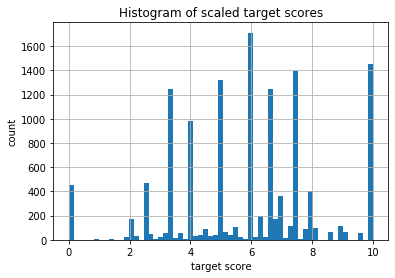

In [46]:
# score histogram
y.hist(bins=61)
plt.title('Histogram of scaled target scores')
plt.xlabel('target score')
plt.ylabel('count')
plt.savefig('image6.png', dpi=300)
plt.show()

In [47]:
from sklearn.model_selection import train_test_split

# Data to be split
X_train, X_test, y_train, y_test, scores_train, scores_test = \
        train_test_split(
                X, 
                y, 
                scores,
                test_size=0.2, 
                random_state=26
                )

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print('scores_train size: {}'.format(scores_train.shape))
print('scores_test size: {}'.format(scores_test.shape))

X_train size: (10380, 300)
X_test size: (2596, 300)
y_train size: (10380, 1)
y_test size: (2596, 1)
scores_train size: (10380, 4)
scores_test size: (2596, 4)


In [48]:
output_dim = y.shape[1]
input_dim = X.shape[1]
dropout = 0.2

def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(14, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) 
        model.add(Dropout(dropout))

# Classification:
#         model.add(Dense(output_dim, activation='softmax'))

# Regression:
        model.add(Dense(output_dim))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(input_dim,1))

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(output_dim, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(input_dim,1))

        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(dropout)(x)
        x = Flatten()(x)
        outputs = Dense(output_dim, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

### Model Architecture

Of the three model architectures the multi-layer perceptron, or 'mlp', consistently produced the highest kappa scores in the shortest amount of calculation time. 

In [49]:
# Define keras model
model = None
# Using MLP in kernel for speed
model = build_model('mlp')
# model = build_model('cnn')
# model = build_model('lstm')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_train.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 14)                4214      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 15        
Total params: 4,229
Trainable params: 4,229
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Compile the model
# Optimizer
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Classification:
# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

# Regression:
model.compile(optimizer=sgd, loss='mse', metrics=['mse','mae'])

In [53]:
# Define number of epochs
epochs = 100

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
#                       validation_split=0.3,
                      epochs=epochs, batch_size=15, verbose=0)

# Wide & Deep Network

In [ ]:
# Select and scale features on normal distribution
additional_features = pd.read_pickle('preprocessedTrainingNoEssay.pkl')

feature_list = [  
    "word_count",
    "TTR",
    "readability",
    "unique_token_count",
    "ner",
    "sw_ratio",
    "ners_ratio"]

additional_features = additional_features[feature_list]

stdscaler = StandardScaler()
additional_features = stdscaler.fit_transform(additional_features)
additional_features.shape

(12976, 31)

In [ ]:
# Combine topic number, target score, additional features and cleaned word vectors
all_data = pd.concat([training_set[['topic','target_score']], pd.DataFrame(additional_features), pd.DataFrame(cleaned_vec)], axis=1)
all_data.shape

(12976, 333)

### Results

In [54]:
"""Classification: Test set predictions """
# y_proba = model.predict(X_test)
# y_pred = pd.Series(y_proba.argmax(axis=-1))

# Classification, if using pd.get_dummies:
# y_t = pd.Series(y_test.columns[np.where(y_test != 0)[1]])

# Classification, if using OneHotEncoder:
# y_t = csr_matrix.argmax(y_test, axis=1)
# y_t = pd.Series(np.squeeze(np.asarray(y_t)))

# Regression, use 'y_test'

'Classification: Test set predictions '

In [55]:
"""
Regression
True y, not needed for kappa metric because already passed with train, test, split
Used to verify reverse scaling
"""
y_pred = pd.DataFrame(model.predict(X_test).reshape(-1))

In [56]:
"""Reverse scaling back to original target score scales"""

# Merge results
results = scores_test.reset_index(drop=True)\
                    .join(y_pred)\
                    .rename(columns={0:'y_pred'})\
                    .sort_values(by='topic')\
                    .reset_index(drop=True)
results.head()

,index,topic,target_score,scaled,y_pred
0,1751,1,10,8.0,6.313411
1,1075,1,12,10.0,6.444101
2,383,1,10,8.0,6.584554
3,706,1,10,8.0,6.738923
4,831,1,10,8.0,6.746907


Histograms of true and predicted target scores show generally a good agreement with the distribution trend. The plots are somewhat misleading since the scaled target scores have the same number of unique values before and after scaling. Since the Kappa metric calculates the distance, the spread of predicted values is not as worrisome.

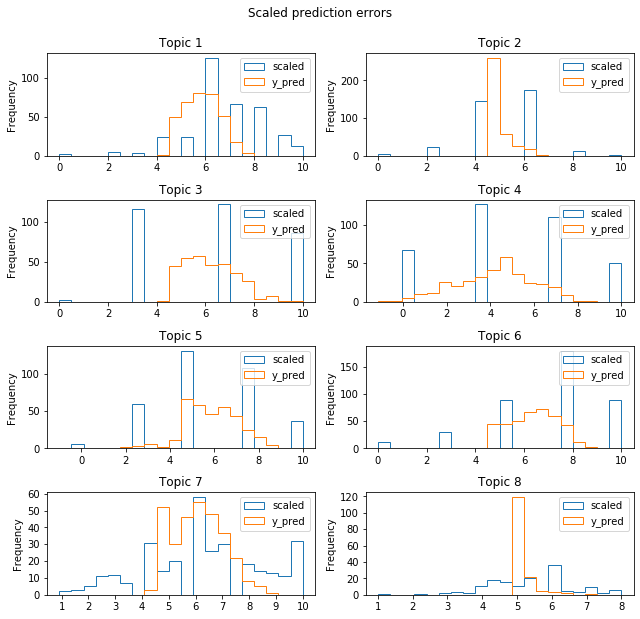

In [57]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            [['scaled', 'y_pred']]\
            .plot.hist(histtype='step', bins=20, ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Scaled prediction errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Prediction errors are greatest at the highest and lowest scores. Typically, the extreme scores have low representation and therefore the highest expected variance, therefore this is, once again, less worrisome.

KeyError: 'Column not found: diff'

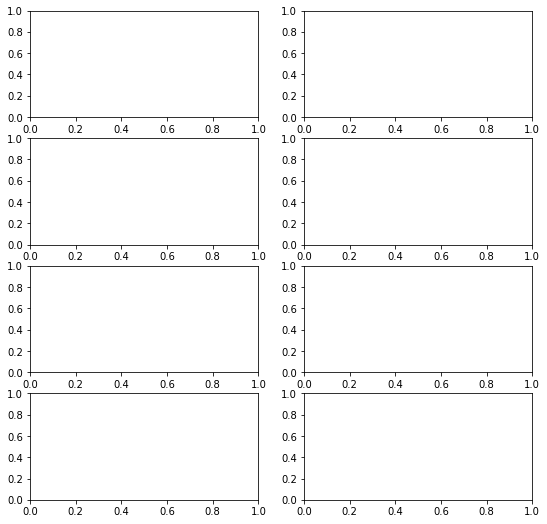

In [60]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            .groupby('target_score')['diff']\
            .median()\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Scaled prediction errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [59]:
""" Create list of tuples with min/max target scores sorted by topic number.
 Performed here on results in case min/max values didn't pass through train_test_split"""

score_df = results.groupby('topic')['target_score'].agg(['min', 'max'])  
score_ranges = list(zip(score_df['min'], score_df['max'])) 

"""Shrink back to original range by topic number:"""
y_p_df = pd.Series()
y_t_df = pd.Series()

for topic in range(1,9):
    scaler = MinMaxScaler(score_ranges[topic-1])
    scaled_pred = results[results.topic == topic]['y_pred'].to_frame()
    y_pred_shrunk = scaler.fit_transform(scaled_pred).round(0).astype('int')
    scaled_true = results[results.topic == topic]['scaled'].to_frame()
    y_true_shrunk = scaler.fit_transform(scaled_true).round(0).astype('int')
    y_p_df = y_p_df.append(pd.Series(np.squeeze(np.asarray(y_pred_shrunk))), ignore_index=True)
    y_t_df = y_t_df.append(pd.Series(np.squeeze(np.asarray(y_true_shrunk))), ignore_index=True)
    
# Append to results df
results['pred'] = y_p_df
results['y_true'] = y_t_df
results.head()

,index,topic,target_score,scaled,y_pred,pred,y_true
0,1751,1,10,8.0,6.313411,8,10
1,1075,1,12,10.0,6.444101,9,12
2,383,1,10,8.0,6.584554,9,10
3,706,1,10,8.0,6.738923,9,10
4,831,1,10,8.0,6.746907,9,10


The close agreement between true and predicted essay scores becomes apparent after re-scaling to their original ranges and plotting on a log scale by count.

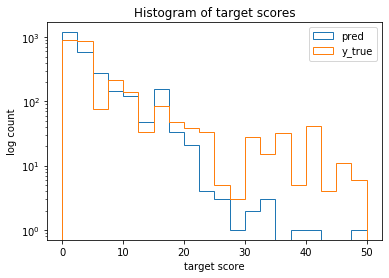

In [61]:
# score histogram

results[['pred', 'y_true']].plot.hist(histtype='step', bins=20, logy=True)
plt.title('Histogram of target scores')
plt.xlabel('target score')
plt.ylabel('log count')
plt.savefig('image8.png', dpi=300)
plt.show()

In [ ]:
# Classification accuracy:
# print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
#       (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

### A note on kappa scores

Some previous studies apply the kappa metric directly to the complete set of essays. Due to the differences in scale, essay topics (sets) that have a narrow scoring range will end up with significantly smaller weighted distances and thus artificially high kappa scores. Kappa scores of up to 94.5% have been reported with this metric.

Other studies calculate the kappa score for each topic individually and then report the geometric mean.

The method most likely used in the original Kaggle competition (there is some doubt whether the published code matches the one actually used), uses the quadratic weighted kappa for each set individually and then calculates the mean of the quadratic weighted kappas after applying Fisher's r-to-z transform, which is approximately a variance-stabilizing transformation. Each set is weighted by a factor of one, except for topic 2 which has two domain raters which are each weighted 0.5. It is not clear why the scores are not weighted by the number of essays in each set, then again, the actual formulas used in the competition have not been published.

The kappa scores from the original competition were based on comparison to unpublished test data scores. Since all published work on this data set only used the training data set, kappas cannot be compared directly to competition results.

Finally, most published work used a subset of essay sets (topics). Omitting topics is likely going to change kappa scores for better or worse.

In [62]:
k = kappa(results.pred, results.target_score, weights='quadratic')
print('Combined essay kappa score: {:.4f}'.format(k))

Combined essay kappa score: 0.7265


The combined essay topics kappa score is much higher than that obtained from individual topics, however, as noted above, this is deceptive, as shown in a recalculation below:

In [63]:
qwk = []
# weights = []
for topic in range(1,9):
    qwk.append(
            kappa(results[results.topic == topic]['target_score'], 
                  results[results.topic == topic]['pred'],
                    weights='quadratic'))
#     weights.append(len(results[results.topic==topic])/X_test.shape[0])    
mqwk = mean_quadratic_weighted_kappa(qwk, weights=1)
print('Weighted by topic Kappa score: {:.2f}%'.format(mqwk * 100))

Weighted by topic Kappa score: 32.02%


In [64]:
qwk

[0.4120360463180922,
 0.08587386363334548,
 0.23864434800578627,
 0.5226503923278116,
 0.3999583087238995,
 0.4733246682586222,
 0.3100440019752859,
 0.04858649790903102]

In [65]:
# kappa for two human raters
qwk = []
# weights = []
for topic in range(1,9):
    qwk.append(
            kappa(training_set[training_set.topic == topic]['rater1_domain1'], 
                  training_set[training_set.topic == topic]['rater2_domain1'],
                    weights='quadratic'))
#     weights.append(len(results[results.topic==topic])/X_test.shape[0])    
mqwk = mean_quadratic_weighted_kappa(qwk, weights=1)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Weighted by topic Kappa score: 0.7612


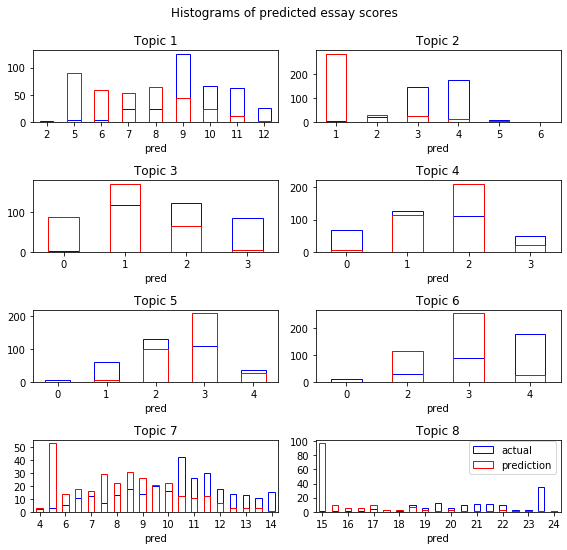

In [66]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,8), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            .groupby('y_true')['y_true']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='b', label='actual')
        results[results['topic'] == topic_number]\
            .groupby('pred')['pred']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='r', label='prediction')
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of predicted essay scores')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

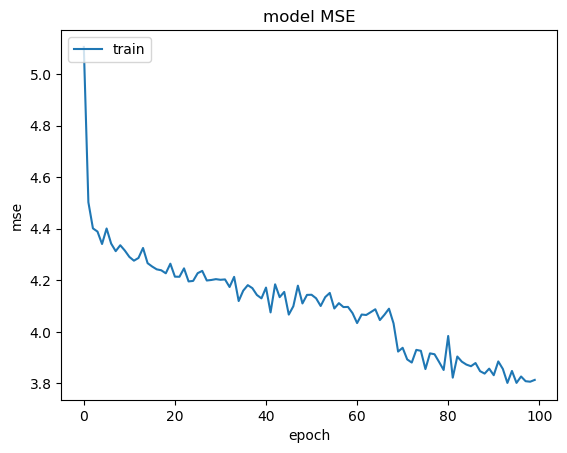

KeyError: 'val_loss'

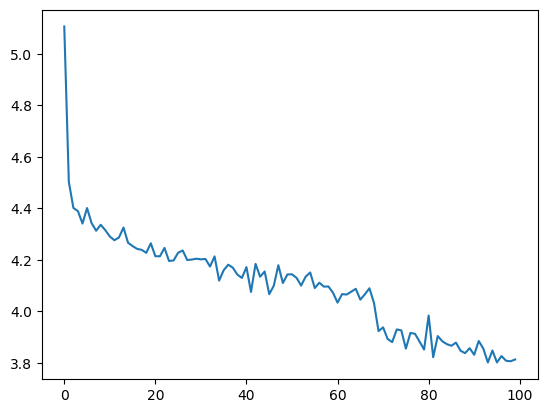

In [76]:
"""
Use this for plotting regression mean-squared error
Validation split must be enabled during model fit.
"""
# Plot model mse over epochs
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['mse'])
plt.plot(estimator.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
# plt.ylim(0,300)
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

The most significant improvement occurs in the first 10 or 20 epochs, however the model continues to improve slightly with additional epochs.

In [ ]:
"""Use this for plotting classification accuracy"""
# # Plot model accuracy over epochs
# sns.reset_orig()   # Reset seaborn settings to get rid of black background
# plt.plot(estimator.history['acc'])
# plt.plot(estimator.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper left')
# plt.show()

# # Plot model loss over epochs
# plt.plot(estimator.history['loss'])
# plt.plot(estimator.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'], loc='upper left')
# plt.show()

In [ ]:
# Check for scaling errors
errors = len(results.query('y_true != target_score')[['topic', 'target_score', 'y_true']])

print('{:.1f}% of target scores did not revert back to their original value.'.format(errors/results.shape[0] * 100))

0.0% of target scores did not revert back to their original value.


## Summary

Adding Word2Vec word embeddings to the feature set and applying a neural network model produces superior results compared to traditional machine learning algorithms. 

Of all the model architectures attempted, a multi-layer perceptron with surprisingly few nodes in the hidden layer returned the highest Kappa score. Additional hidden layers did not improve the model.

Automatic scoring can be framed as both a classification or a regression problem. The highest target metrics (mean quadratic weighted kappa) were found using regression analysis.

Comparisons to the original Kaggle competition and later attempts are often unfair due to differences in data sets and methods of calculating kappa. The results obtained in this notebook are among the highest, if not the highest currently published.

## Outlook

Additional optimization is definitely possibly by tweaking hyperparameters and calculating more epochs. Additional features could be extracted and added to the feature set. While this would almost certainly result in higher kappa scores, the additional gain wouldn't outweigh the benefit. Perhaps the biggest obstacle is the limited data. If some day scores for the validation and test data sets are released, it would be worthwhile revisiting the problem set.